# [Assignment 9](https://ovgu-ailab.github.io/idl2023/assignment9.html)

Colaborative Work from Adrian Bremer & Philipp Reinig

## Setup

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Load CIFAR 10

In [4]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()

print((train_imgs.shape, train_lbls.shape, test_imgs.shape, test_lbls.shape))
print((train_imgs.dtype, train_lbls.dtype, test_imgs.dtype, test_lbls.dtype))

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))
(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'))


In [12]:
BATCH_SIZE = 128

train_data = tf.data.Dataset.from_tensor_slices(
    (train_imgs.astype(np.float32) / 255, train_lbls.astype(np.int32))
).shuffle(60000).batch(BATCH_SIZE).repeat()
test_data = tf.data.Dataset.from_tensor_slices(
    (test_imgs.astype(np.float32) / 255, test_lbls.astype(np.int32))
).shuffle(60000).batch(BATCH_SIZE)

2023-12-12 13:39:20.650381: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


## Training own model

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", strides=2),
    tf.keras.layers.MaxPooling2D(strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu", strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding="same"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu", strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="valid", activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Dense(units=10)
])

model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

#model.build(tf.keras.Input((BATCH_SIZE, 32, 32, 3)))

In [20]:
model.fit(train_data, epochs=20, steps_per_epoch=50)

Epoch 1/20
50/50 [==============================] - 4s 61ms/step - loss: 1.9084 - accuracy: 0.3464
Epoch 2/20
50/50 [==============================] - 3s 59ms/step - loss: 1.4750 - accuracy: 0.4686
Epoch 3/20
50/50 [==============================] - 3s 58ms/step - loss: 1.3409 - accuracy: 0.5294
Epoch 4/20
50/50 [==============================] - 3s 59ms/step - loss: 1.2742 - accuracy: 0.5487
Epoch 5/20
50/50 [==============================] - 3s 59ms/step - loss: 1.2031 - accuracy: 0.5747
Epoch 6/20
50/50 [==============================] - 3s 58ms/step - loss: 1.1562 - accuracy: 0.5873
Epoch 7/20
50/50 [==============================] - 3s 59ms/step - loss: 1.1037 - accuracy: 0.6102
Epoch 8/20
50/50 [==============================] - 3s 59ms/step - loss: 1.0426 - accuracy: 0.6363
Epoch 9/20
50/50 [==============================] - 3s 58ms/step - loss: 0.9590 - accuracy: 0.6664
Epoch 10/20
50/50 [==============================] - 3s 58ms/step - loss: 0.9600 - accuracy: 0.6764
Epoch 11/

In [21]:
model.evaluate(test_data)

79/79 [==============================] - 1s 14ms/step - loss: 1.0148 - accuracy: 0.6537


[1.0148084163665771, 0.6536999940872192]

## Saliency Maps

In [78]:
def calc_saliency(model, inp_batch, lbl_batch):
    inp_batch = tf.Variable(inp_batch)
    lbl_batch = tf.Variable(lbl_batch)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(inp_batch)
        logits = model(inp_batch)
        probs = tf.nn.softmax(logits)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(lbl_batch, logits)
    # need to do this seperatly, because tape.gradient sums up the gradients for all targets
    # wierd...
    logit_grads = tape.gradient(logits, inp_batch)
    prob_grads = tape.gradient(probs, inp_batch)
    loss_grads = tape.gradient(loss, inp_batch)
    return (logit_grads, prob_grads, loss_grads)

#def plot_saliency(saliency, inp):
    

[6]


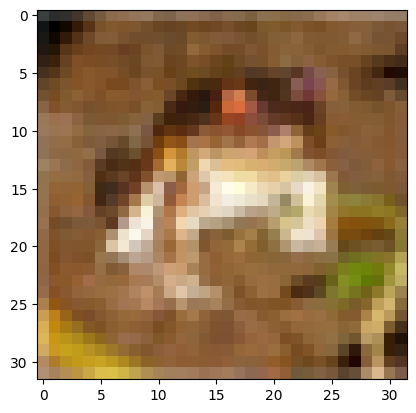

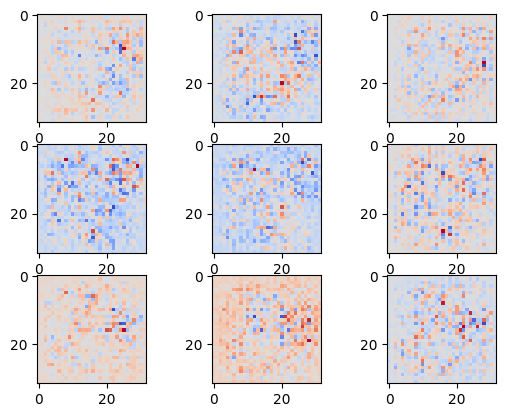

In [80]:
inp = train_imgs[0].astype(np.float32) / 255
lbl = train_lbls[0].astype(np.int32)
print(lbl)
plt.imshow(inp)
plt.show()

lg,pg,lossg = calc_saliency(model, [inp], lbl)
lg,pg,lossg = (lg[0], pg[0],lossg[0])
fig, ax = plt.subplots(3,3)
for i in range(3):
    ax[0,i].imshow(lg[:,:,i], cmap='coolwarm')
    ax[1,i].imshow(pg[:,:,i], cmap='coolwarm')
    ax[2,i].imshow(lossg[:,:,i], cmap="coolwarm")
plt.show()

In [ ]:
# Blurring
